In [1]:
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd
import scipy
import h5py as h5
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [3]:
from gambit.kmers import KmerSpec

In [4]:
%matplotlib inline

## Setup

In [24]:
DATESTR = '210929'
NBNAME = DATESTR + '-analyze-results'

In [25]:
infiles = dict(
    genomes=Path('data-processed/210902-get-genomes/210902-mash-genomes-filtered.csv'),
    ani=Path('data-intermediate/210904-fastani'),
    mash=Path('data-intermediate/210902-mash-distances'),
)

## Load data

In [26]:
genomes_df = pd.read_csv(infiles['genomes'])
ngenomes = genomes_df.shape[0]

### ANI

In [6]:
with h5.File(infiles['ani'] / 'ani-pairwise.h5') as file:
    ani = pd.Series(
        file['ani_mean'][:],
        index=pd.MultiIndex.from_arrays(
            [file['genome1'][:], file['genome2'][:]],
            names=['g1', 'g2'],
        ),
        name='ani',
    )

### Mash

In [11]:
with h5.File(infiles['mash'] / 'mash-distances.h5') as file:
    assert np.all(file['index1'][:] == ani.index.get_level_values('g1'))
    assert np.all(file['index2'][:] == ani.index.get_level_values('g2'))
    
    mash_dists = file['distances'][:]

    mash_df = pd.DataFrame(
        mash_dists.T,
        index=ani.index,
        columns=pd.MultiIndex.from_arrays([file['k'], file['sketch_size']], names=['k', 's'])
    )

In [12]:
mash_k = mash_df.columns.unique('k')
mash_s = mash_df.columns.unique('s')

## ANI

### Distribution

<AxesSubplot:xlabel='ani', ylabel='Count'>

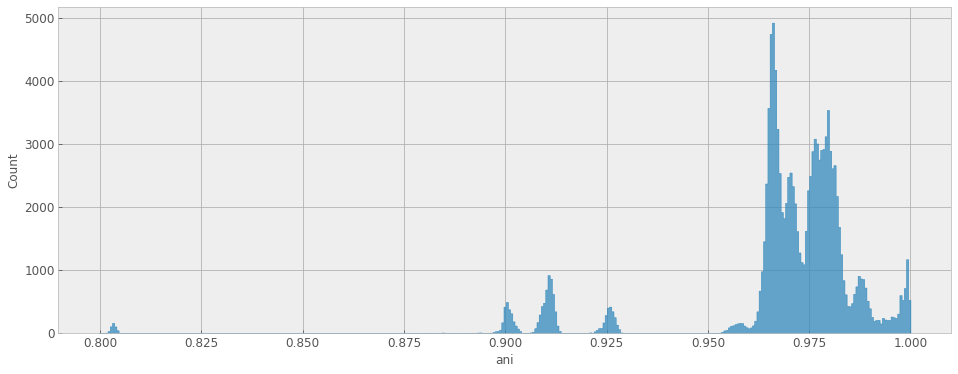

In [9]:
plt.figure(figsize=(16, 6))
sns.histplot(ani, element='step')

## Mash

In [13]:
mash_stats = pd.DataFrame(dict(
     ani_pearson=mash_df.apply(lambda d: scipy.stats.pearsonr(d, ani)[0]),
     ani_spearman=mash_df.apply(lambda d: scipy.stats.spearmanr(d, ani).correlation),
))

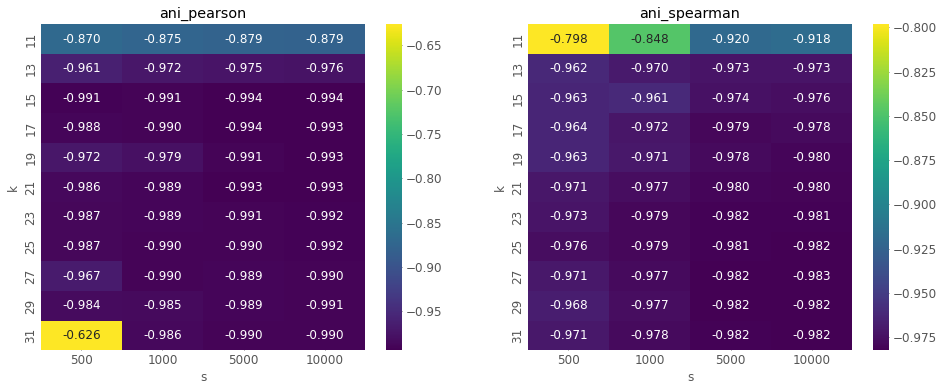

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

for i, col in enumerate(['ani_pearson', 'ani_spearman']):
    _df = pd.pivot(mash_stats.reset_index(), 'k', 's', col)
    sns.heatmap(_df, cmap='viridis', ax=axs[i], annot=True, fmt='.3f')
    axs[i].set_title(col)

In [15]:
_mash_cmp = mash[[15, 21, 27]].stack(['s', 'k']).to_frame('mash').join(1 - ani)

### Recreate Fig. 2

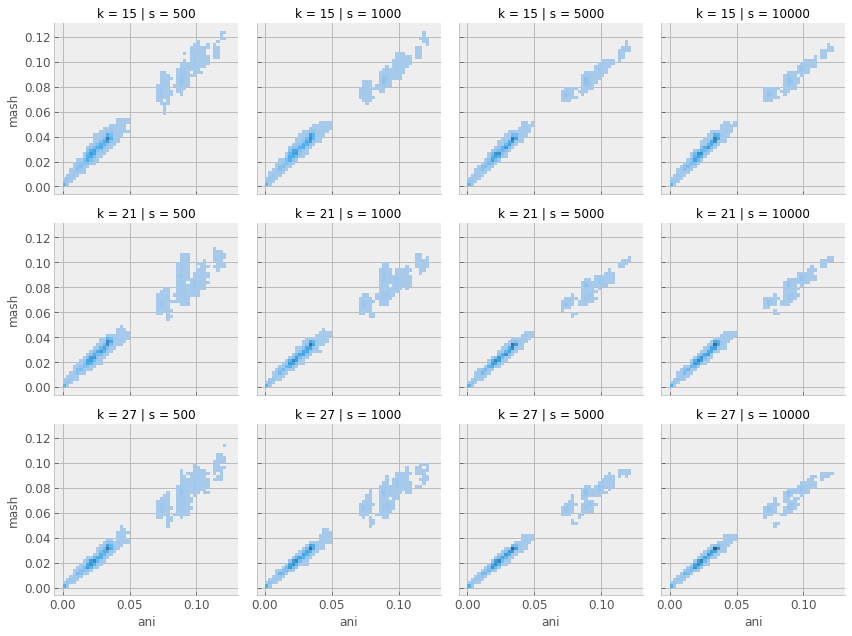

In [23]:
sns.displot(_mash_cmp, x='ani', y='mash', row='k', col='s', bins=50, binrange=((0, .125), (0, .125)), height=3)